Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

A


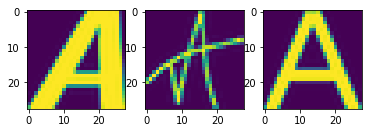

B


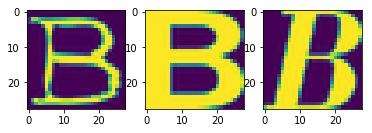

C


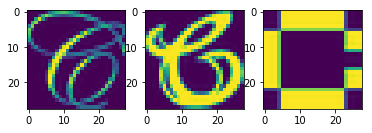

D


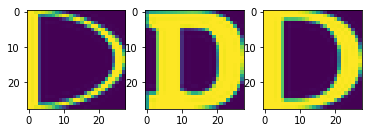

E


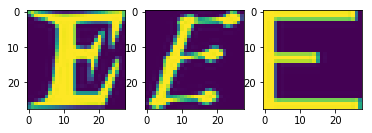

F


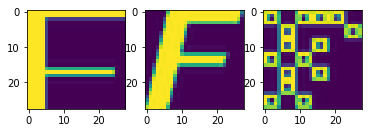

G


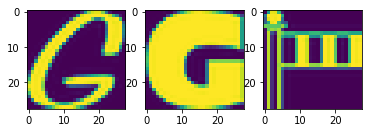

H


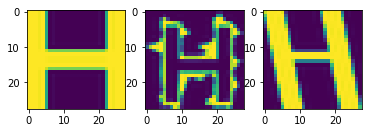

I


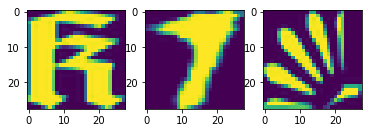

J


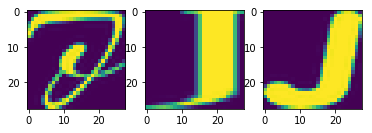

In [4]:
import random

random.seed(1)

for k in train_folders:

    fig = plt.figure()

    print(k[-1])
    
    fig.add_subplot(1,3,1)
    img_1 = (random.choice(os.listdir(k)))
    plt.imshow(plt.imread(k + '/' + img_1))
    
    fig.add_subplot(1,3,2)
    img_2 = (random.choice(os.listdir(k)))
    plt.imshow(plt.imread(k + '/' + img_2))
    
    fig.add_subplot(1,3,3)
    img_3 = (random.choice(os.listdir(k)))
    plt.imshow(plt.imread(k + '/' + img_3))
    
    plt.show()


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [6]:
labels = 'ABCDEFGHIJ'
figure = plt.figure()
for i in range(len(train_datasets)):
    load = pickle.load(open(train_datasets[i], 'r'))
    figure.add_subplot(1, 10, i+1)
    plt.imshow(load[1], cmap='viridis')
    plt.xlabel(labels[i])
    plt.xticks([])
    plt.yticks([])
    
fig.show()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

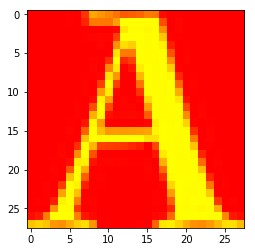

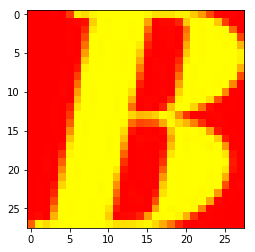

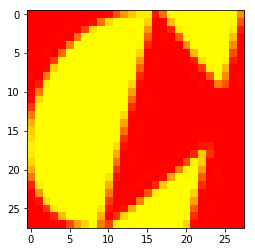

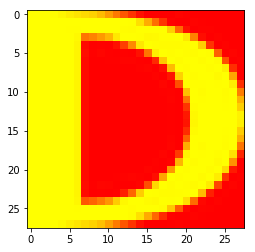

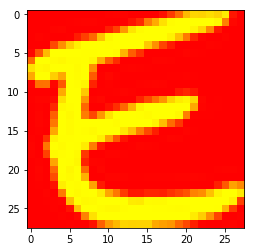

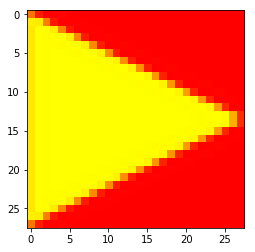

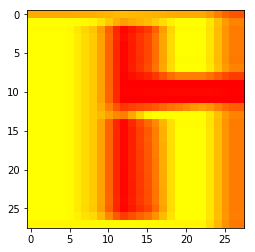

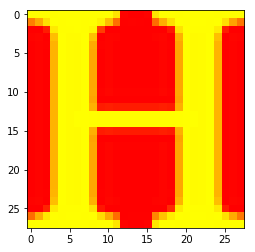

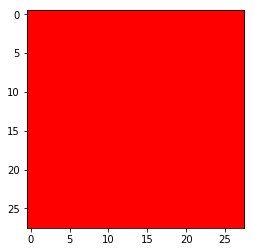

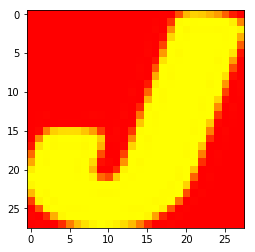

In [6]:
for k in range(len(train_datasets)):
    pickle_file = train_datasets[k]
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        sample_idx = np.random.randint(len(letter_set))  # pick a random image index
        sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
        plt.figure()
        plt.imshow(sample_image, cmap='autumn')  # display it

Matplotlib `cmap` reference can be found [here](http://matplotlib.org/examples/color/colormaps_reference.html).

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

NB: Perhaps problem 3 is in the wrong spot?  Should the class balanced also be checked after the train, test, and validation datasets have been formed?

In [8]:
labels = 'ABCDEFGHIJ'

print('Checking training datasets.')

class_lens = []
for i in range(len(train_datasets)):
    load = pickle.load(open(train_datasets[i], 'r'))
    class_lens.append(len(load))

for k in range(10):
    print(str(class_lens[k]) + ' examples of ' + labels[k] + '\'s in the train dataset.')
    
print('Checking testing datasets.')

test_lens = []
for i in range(len(test_datasets)):
    load = pickle.load(open(test_datasets[i], 'r'))
    test_lens.append(len(load))
    
for k in range(10):
    print(str(test_lens[k]) + ' examples of ' + labels[k] + '\'s in the test dataset.')

Checking training datasets.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [9]:
labels = 'ABCDEFGHIJ'

print('Checking training datasets.')

class_lens = []
for i in range(len(train_datasets)):
    load = pickle.load(open(train_datasets[i], 'r'))
    class_lens.append(len(load))

for k in range(10):
    print(str(class_lens[k]) + ' examples of ' + labels[k] + '\'s in the train dataset.')
    
print('Checking testing datasets.')

test_lens = []
for i in range(len(test_datasets)):
    load = pickle.load(open(test_datasets[i], 'r'))
    test_lens.append(len(load))
    
for k in range(10):
    print(str(test_lens[k]) + ' examples of ' + labels[k] + '\'s in the test dataset.')

Checking training datasets.


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [7]:
labels = 'ABCDEFGHIJ'

print('Checking training datasets.')

class_lens = []
for k in range(len(train_datasets)):
    pickle_file = train_datasets[k]
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        class_lens.append(len(letter_set))
        
for k in range(10):
    print(str(class_lens[k]) + ' examples of ' + labels[k] + '\'s in the train dataset.')

test_lens = []
for k in range(len(test_datasets)):
    pickle_file = train_datasets[k]
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        test_lens.append(len(letter_set))
        
for k in range(10):
    print(str(test_lens[k]) + ' examples of ' + labels[k] + '\'s in the test dataset.')

Checking training datasets.
52909 examples of A's in the train dataset.
52911 examples of B's in the train dataset.
52912 examples of C's in the train dataset.
52911 examples of D's in the train dataset.
52912 examples of E's in the train dataset.
52912 examples of F's in the train dataset.
52912 examples of G's in the train dataset.
52912 examples of H's in the train dataset.
52912 examples of I's in the train dataset.
52911 examples of J's in the train dataset.
52909 examples of A's in the test dataset.
52911 examples of B's in the test dataset.
52912 examples of C's in the test dataset.
52911 examples of D's in the test dataset.
52912 examples of E's in the test dataset.
52912 examples of F's in the test dataset.
52912 examples of G's in the test dataset.
52912 examples of H's in the test dataset.
52912 examples of I's in the test dataset.
52911 examples of J's in the test dataset.


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [10]:
# func to check images after shuffle+split

def check_data(dataset, labelset):
    # class labels in a string
    labels = 'ABCDEFGHIJ'
    
    # use plt to plot a 1x3 image
    fig = plt.figure()
    
    for k in range(3):
        fig.add_subplot(1, 3, k+1) 
        plt.imshow(dataset[k], cmap='plasma')
        # use numbered label to refer to correct character
        plt.xlabel(labels[labelset[k]])
    fig.show()

/home/kt12/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


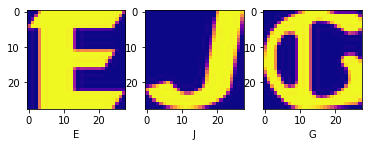

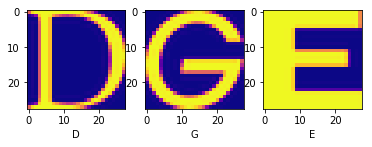

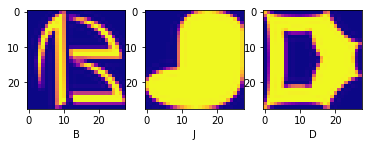

In [11]:
check_data(train_dataset, train_labels)
check_data(test_dataset,test_labels)
check_data(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [14]:
%%time
import hashlib

train_hashes_s = [hashlib.sha1(k).digest() for k in train_dataset]
valid_hashes_s = [hashlib.sha1(k).digest() for k in valid_dataset]
test_hashes_s  = [hashlib.sha1(k).digest() for k in test_dataset]

train_val_overlap = np.in1d(train_hashes_s, valid_hashes_s)
train_test_overlap = np.in1d(train_hashes_s, test_hashes_s)
val_test_overlap = np.in1d(valid_hashes_s, test_hashes_s)

print('Train and val overlap: ' + str(train_val_overlap.sum()))
print('Train and test overlap: ' + str(train_test_overlap.sum()))
print('Val and test overlap: ' + str(val_test_overlap.sum()))

Train and val overlap: 3506
Train and test overlap: 3430
Val and test overlap: 193
CPU times: user 1.28 s, sys: 4 ms, total: 1.29 s
Wall time: 1.29 s


In [19]:
'''funct comparing each pixel of two data sets'''

def compare_datasets(first_set, second_set):
    overlap = []
    for i in range(len(first_set)):
        for j in range(len(second_set)):
            if sum(1 for k in range(784)
                   if first_set[i].ravel()[k] == second_set[j].ravel()[k]) == 784:
                overlap.append(i)
    return overlap

In [112]:
%%time 
(valid_dataset[99]==train_dataset[19]).all()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 139 µs


False

In [22]:
# Tests every image against every image

def check_overlap(first_set, second_set):
    overlap = 0
    for i in range(len(first_set)):
        for j in range(len(second_set)):
            if (first_set[i] == second_set[j]).all():
                overlap += 1
    return overlap

In [118]:
%%time
check_overlap(valid_dataset, test_dataset)

CPU times: user 13min 16s, sys: 28 ms, total: 13min 16s
Wall time: 13min 16s


16151

In [119]:
%%time
check_overlap(valid_dataset, train_dataset)

CPU times: user 4h 20min 37s, sys: 3.85 s, total: 4h 20min 41s
Wall time: 4h 20min 40s


245738

In [120]:
%%time
check_overlap(test_dataset, train_dataset)

CPU times: user 4h 18min, sys: 3.36 s, total: 4h 18min 3s
Wall time: 4h 18min 2s


274021

Check to see if `in` operator works as expected

In [121]:
valid_dataset[99] in train_dataset

True

In [124]:
valid_dataset[1] in test_dataset

True

In [127]:
# The 'in' operator does not seem to work as expected
c = 0
for k in range(10000):
    if valid_dataset[k] in test_dataset:
        c += 1
print(c)

10000


In [23]:
# Only tests images if the labels are the same

def check_labels_overlap(first_set, first_labels, second_set, second_labels):
    overlap = 0
    for i in range(len(first_labels)):
        for j in range(len(second_labels)):
            if first_labels[i] == second_labels[j]:
                if (first_set[i] == second_set[j]).all():
                    overlap += 1
    return overlap

In [21]:
%%time
check_labels_overlap(valid_dataset, valid_labels, test_dataset, test_labels)

CPU times: user 1min 57s, sys: 32 ms, total: 1min 57s
Wall time: 1min 57s


15877

Use `hashlib` and check to see speeds of sha1 vs md5, hex vs digest

In [14]:
import hashlib

In [16]:
%%time

train_hashes_s = [hashlib.sha1(k).digest() for k in train_dataset]
valid_hashes_s = [hashlib.sha1(k).digest() for k in valid_dataset]
test_hashes_s  = [hashlib.sha1(k).digest() for k in test_dataset]

train_val_overlap = np.in1d(train_hashes_s, valid_hashes_s)
train_test_overlap = np.in1d(train_hashes_s, test_hashes_s)
val_test_overlap = np.in1d(valid_hashes_s, test_hashes_s)

print('Train and val overlap: ' + str(train_val_overlap.sum()))
print('Train and test overlap: ' + str(train_test_overlap.sum()))
print('Val and test overlap: ' + str(val_test_overlap.sum()))

Train and val overlap: 3526
Train and test overlap: 3480
Val and test overlap: 186
CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.02 s


In [18]:
%%time

train_hashes_s = [hashlib.sha1(k).hexdigest() for k in train_dataset]
valid_hashes_s = [hashlib.sha1(k).hexdigest() for k in valid_dataset]
test_hashes_s  = [hashlib.sha1(k).hexdigest() for k in test_dataset]

train_val_overlap = np.in1d(train_hashes_s, valid_hashes_s)
train_test_overlap = np.in1d(train_hashes_s, test_hashes_s)
val_test_overlap = np.in1d(valid_hashes_s, test_hashes_s)

print('Train and val overlap: ' + str(train_val_overlap.sum()))
print('Train and test overlap: ' + str(train_test_overlap.sum()))
print('Val and test overlap: ' + str(val_test_overlap.sum()))

Train and val overlap: 3526
Train and test overlap: 3480
Val and test overlap: 186
CPU times: user 2.1 s, sys: 4 ms, total: 2.1 s
Wall time: 2.11 s


In [17]:
%%time

train_hashes_s = [hashlib.md5(k).digest() for k in train_dataset]
valid_hashes_s = [hashlib.md5(k).digest() for k in valid_dataset]
test_hashes_s  = [hashlib.md5(k).digest() for k in test_dataset]

train_val_overlap = np.in1d(train_hashes_s, valid_hashes_s)
train_test_overlap = np.in1d(train_hashes_s, test_hashes_s)
val_test_overlap = np.in1d(valid_hashes_s, test_hashes_s)

print('Train and val overlap: ' + str(train_val_overlap.sum()))
print('Train and test overlap: ' + str(train_test_overlap.sum()))
print('Val and test overlap: ' + str(val_test_overlap.sum()))

Train and val overlap: 3526
Train and test overlap: 3480
Val and test overlap: 186
CPU times: user 2.08 s, sys: 0 ns, total: 2.08 s
Wall time: 2.09 s


In [19]:
%%time

train_hashes_s = [hashlib.md5(k).hexdigest() for k in train_dataset]
valid_hashes_s = [hashlib.md5(k).hexdigest() for k in valid_dataset]
test_hashes_s  = [hashlib.md5(k).hexdigest() for k in test_dataset]

train_val_overlap = np.in1d(train_hashes_s, valid_hashes_s)
train_test_overlap = np.in1d(train_hashes_s, test_hashes_s)
val_test_overlap = np.in1d(valid_hashes_s, test_hashes_s)

print('Train and val overlap: ' + str(train_val_overlap.sum()))
print('Train and test overlap: ' + str(train_test_overlap.sum()))
print('Val and test overlap: ' + str(val_test_overlap.sum()))

Train and val overlap: 3526
Train and test overlap: 3480
Val and test overlap: 186
CPU times: user 2.19 s, sys: 12 ms, total: 2.2 s
Wall time: 2.2 s


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [15]:
# Ready data

sizes = [25, 50, 100, 500, 1000, 5000, 8000]
X = train_dataset.reshape(200000, 784)
X_test = test_dataset.reshape(10000, 784)
X_val = valid_dataset.reshape(10000, 784)

In [16]:
%%time

test_scores = []
val_scores = []

for k in sizes:
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(X[:k], train_labels[:k])
    test_scores.append(clf.score(X_test, test_labels))
    val_scores.append(clf.score(X_val, valid_labels))

CPU times: user 56.2 s, sys: 104 ms, total: 56.4 s
Wall time: 55.2 s


In [17]:
for k in range(len(sizes)):
    print('Training size of:    ' + str(sizes[k]))
    print('Test score of:       ' + str(test_scores[k]))
    print('Validation score of: ' + str(val_scores[k]))
    print(27 * '-')

Training size of:    25
Test score of:       0.502
Validation score of: 0.4631
---------------------------
Training size of:    50
Test score of:       0.6076
Validation score of: 0.5626
---------------------------
Training size of:    100
Test score of:       0.7984
Validation score of: 0.7345
---------------------------
Training size of:    500
Test score of:       0.8241
Validation score of: 0.7582
---------------------------
Training size of:    1000
Test score of:       0.8417
Validation score of: 0.7742
---------------------------
Training size of:    5000
Test score of:       0.8511
Validation score of: 0.781
---------------------------
Training size of:    8000
Test score of:       0.8612
Validation score of: 0.7864
---------------------------


In [18]:
%%time

# Optional Question
clf = LogisticRegression(n_jobs=-1)
clf.fit(X, train_labels)

CPU times: user 23min 12s, sys: 616 ms, total: 23min 12s
Wall time: 23min 13s


In [19]:
all_test = clf.score(X_test, test_labels)
all_val  = clf.score(X_val, valid_labels)

print('After using all training data, the classifier scored:')
print('Test score:       ' + str(all_test))
print('Validation score: ' + str(all_val))

After using all training data, the classifier scored:
Test score:       0.893
Validation score: 0.8232
